### **Setup & Install Required Libraries**

In [ ]:
# Install required packages if not already installed
!pip install --quiet google-cloud-bigquery google-auth google-auth-oauthlib

### **Import Libraries & Connect to BigQuery**

In [ ]:
# Import Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account

# Connect to Google BigQuery
credentials = service_account.Credentials.from_service_account_file('/content/online-retail-dwdm-457717-28a7cf8905bb.json')
client = bigquery.Client(credentials=credentials, project='online-retail-dwdm-457717')

# Helper function to execute queries and return dataframes
def run_query(query):
    df = client.query(query).to_dataframe()
    display(df.head())
    return df


### **OLAP Roll-Up: Monthly Revenue**

,Month,Year,MonthlyRevenue
0,12,2009,1479626.13
1,1,2010,1113245.31
2,2,2010,949168.41
3,3,2010,1219179.68
4,4,2010,1058127.62


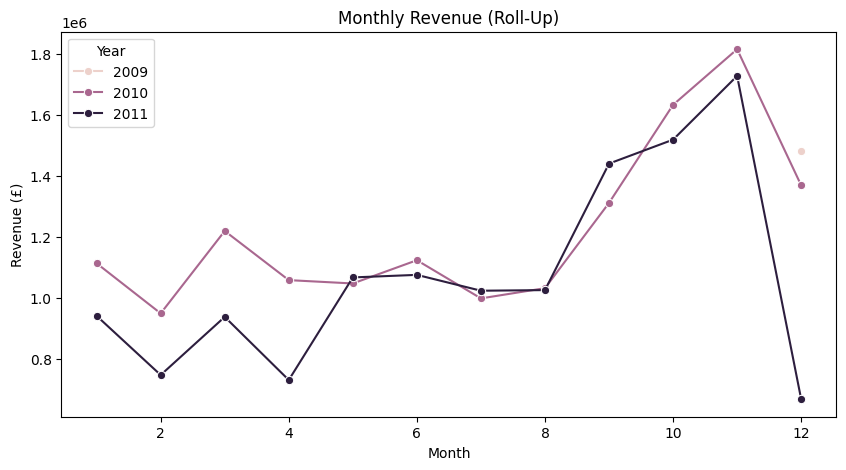

In [ ]:
# SQL query to roll up data from day level to month
query_rollup = """
SELECT
  dt.Month,
  dt.Year,
  SUM(f.TotalPrice) AS MonthlyRevenue
FROM `online-retail-dwdm-457717.online_retail.FactSales` f
JOIN `online-retail-dwdm-457717.online_retail.DimDate` dt ON f.DateKey = dt.DateKey
GROUP BY dt.Year, dt.Month
ORDER BY dt.Year, dt.Month;
"""
monthly_revenue = run_query(query_rollup)

# Visualize the monthly revenue
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_revenue, x='Month', y='MonthlyRevenue', hue='Year', marker='o')
plt.title('Monthly Revenue (Roll-Up)')
plt.ylabel('Revenue (£)')
plt.xlabel('Month')
plt.show()


### **OLAP Drill-Down: Daily Revenue**

,FullDate,DailyRevenue
0,2009-12-01,90253.59
1,2009-12-02,102827.33
2,2009-12-03,145621.66
3,2009-12-04,72341.50
4,2009-12-05,23307.33


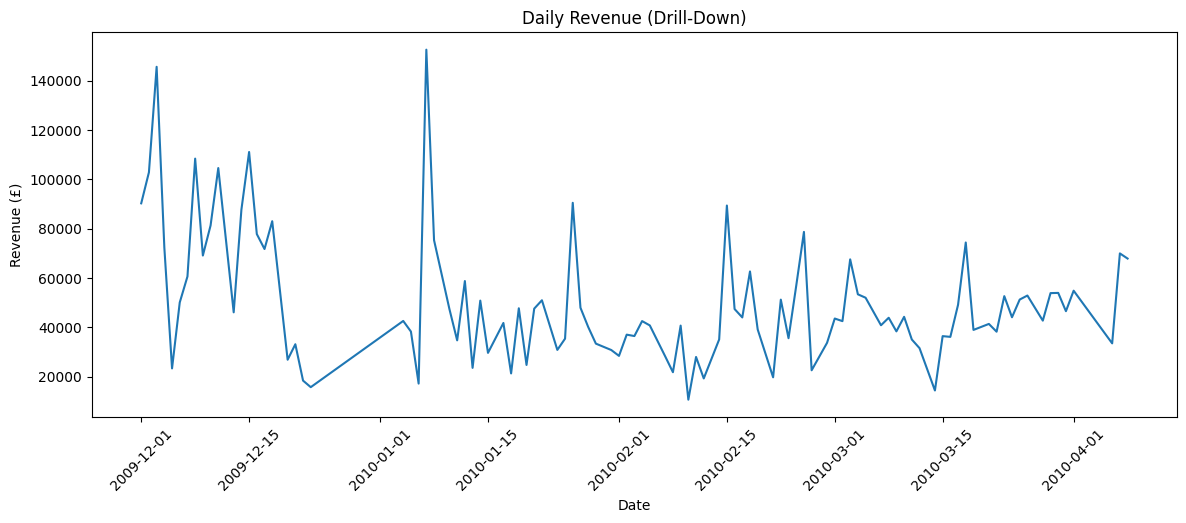

In [ ]:
# SQL query to drill down from month to full date
query_drilldown = """
SELECT
  dt.FullDate,
  SUM(f.TotalPrice) AS DailyRevenue
FROM `online-retail-dwdm-457717.online_retail.FactSales` f
JOIN `online-retail-dwdm-457717.online_retail.DimDate` dt ON f.DateKey = dt.DateKey
GROUP BY dt.FullDate
ORDER BY dt.FullDate;
"""
daily_revenue = run_query(query_drilldown)

# Plot a sample of the daily revenue
plt.figure(figsize=(14, 5))
sample = daily_revenue.head(100)  # Display first 100 days
sns.lineplot(data=sample, x='FullDate', y='DailyRevenue')
plt.title('Daily Revenue (Drill-Down)')
plt.xticks(rotation=45)
plt.ylabel('Revenue (£)')
plt.xlabel('Date')
plt.show()


### **OLAP Slice: Revenue from United Kingdom Only**

In [ ]:
# Slice: filter revenue for customers from United Kingdom
query_slice = """
SELECT
  c.Country,
  SUM(f.TotalPrice) AS Revenue
FROM `online-retail-dwdm-457717.online_retail.FactSales` f
JOIN `online-retail-dwdm-457717.online_retail.DimCustomer` c ON f.CustomerKey = c.CustomerKey
WHERE c.Country = 'United Kingdom'
GROUP BY c.Country;
"""
uk_revenue = run_query(query_slice)


,Country,Revenue
0,United Kingdom,2.394009e+07


### **OLAP Dice: UK Revenue in December**

In [ ]:
# Dice: Filter by both country and month
query_dice = """
SELECT
  c.Country,
  dt.Month,
  SUM(f.TotalPrice) AS Revenue
FROM `online-retail-dwdm-457717.online_retail.FactSales` f
JOIN `online-retail-dwdm-457717.online_retail.DimCustomer` c ON f.CustomerKey = c.CustomerKey
JOIN `online-retail-dwdm-457717.online_retail.DimDate` dt ON f.DateKey = dt.DateKey
WHERE c.Country = 'United Kingdom' AND dt.Month = 12
GROUP BY c.Country, dt.Month;
"""
uk_dec_revenue = run_query(query_dice)


,Country,Month,Revenue
0,United Kingdom,12,3090085.16


### **Save Outputs to CSV**

In [ ]:
# export results to CSV for use in reports
monthly_revenue.to_csv("monthly_revenue.csv", index=False)
daily_revenue.to_csv("daily_revenue.csv", index=False)
uk_revenue.to_csv("uk_revenue.csv", index=False)
uk_dec_revenue.to_csv("uk_december_revenue.csv", index=False)
